# This notebook aims to develop a neural-network based classifier for the coffee bean dataset
## The technology of choice is pytorch

In [6]:
import torch
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("data/beans.csv")
bean_annotations.head()

,img_name,origin_country,variety,processing_method,defect_class
0,columbia-caturra-washed-burnt-0-1.png,columbia,caturra,washed,burnt
1,columbia-caturra-washed-burnt-0-0.png,columbia,caturra,washed,burnt
2,columbia-caturra-washed-burnt-1-1.png,columbia,caturra,washed,burnt
3,columbia-caturra-washed-burnt-1-0.png,columbia,caturra,washed,burnt
4,ethiopia-ethHeirloom-washed-normal-2-2.png,ethiopia,ethHeirloom,washed,normal


In [15]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.bean_annotations)

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = io.imread(img_path)

        annotations = self.bean_annotations.iloc[item, 1:]
        sample = {"image": image, "annotations": annotations}
        return sample

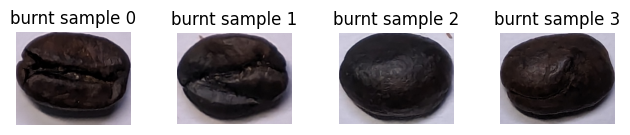

In [32]:
bean_dataset = RoastDefectsDataset(csv_file="data/beans.csv", root_dir="data/processed")

fig = plt.figure()

for i, sample in enumerate(bean_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'{list(sample["annotations"])[3]} sample {i}')
    ax.axis("off")
    plt.imshow(sample["image"])

    if i == 3:
        plt.show()
        break